# 제19강 실습: NSMC 영화평 감정분석

이 노트북에서는 NSMC(Naver Sentiment Movie Corpus) 데이터셋을 사용하여 영화 리뷰의 감정(긍정/부정)을 분류하는 모델을 학습한다.

## 학습 목표
1. 텍스트 데이터를 수치 특성으로 변환하는 방법(Bag-of-Words, TF-IDF)을 이해하고 적용할 수 있다.
2. NSMC 데이터셋으로 감정 분석 모델을 학습하고 평가할 수 있다.
3. 모델의 예측 결과를 해석하고 개선 방향을 제시할 수 있다.

## 0. 환경 설정

In [1]:
# 필요한 패키지 설치 (처음 한 번만 실행)
# !pip install datasets scikit-learn pandas matplotlib seaborn

In [ ]:
# 한글 폰트 파일 다운로드
# !mkdir -p ../fonts
# !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip -O ../fonts/NotoSansCJKkr-hinted.zip
# !unzip ../fonts/NotoSansCJKkr-hinted.zip -d ../fonts
# !rm ../fonts/NotoSansCJKkr-hinted.zip

In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from datasets import load_dataset

# scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 한글 폰트 설정 (matplotlib)
# font_path = os.path.abspath('../fonts/NotoSansCJKkr-Regular.otf')
# prop = fm.FontProperties(fname=font_path)
font_dir = ['../fonts']
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)

plt.rcParams['font.family'] = 'Noto Sans CJK KR'
plt.rcParams['axes.unicode_minus'] = False

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료!")

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


라이브러리 로드 완료!


---
## 1. NSMC 데이터셋 로드

NSMC(Naver Sentiment Movie Corpus)는 네이버 영화 리뷰를 수집한 감정 분석 데이터셋입니다.
- 총 20만 건의 리뷰
- **학습 세트**: 150,000건 / **테스트 세트**: 50,000건
- 레이블: 긍정(1), 부정(0)

In [3]:
# HuggingFace에서 NSMC 데이터셋 로드
dataset = load_dataset("Blpeng/nsmc")

# 데이터셋 구조 확인
print(dataset)

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 50000
    })
})


In [4]:
# 학습/테스트 데이터를 각각 pandas DataFrame으로 변환
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

# 기본 정보 확인
print(f"학습 데이터 크기: {train_df.shape}")
print(f"테스트 데이터 크기: {test_df.shape}")
print(f"\n칼럼: {train_df.columns.tolist()}")

학습 데이터 크기: (150000, 4)
테스트 데이터 크기: (50000, 4)

칼럼: ['Unnamed: 0', 'id', 'document', 'label']


In [5]:
# 학습 데이터 처음 10개 확인
train_df.head(10)

,Unnamed: 0,id,document,label
0,0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,2,10265843,너무재밓었다그래서보는것을추천한다,0
3,3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


### 1.1 데이터 탐색

In [6]:
# 레이블 분포 확인
print("학습 데이터 레이블 분포:")
print(train_df['label'].value_counts())
print(f"\n긍정 비율: {train_df['label'].mean():.2%}")

print("\n테스트 데이터 레이블 분포:")
print(test_df['label'].value_counts())
print(f"\n긍정 비율: {test_df['label'].mean():.2%}")

학습 데이터 레이블 분포:
label
0    75173
1    74827
Name: count, dtype: int64

긍정 비율: 49.88%

테스트 데이터 레이블 분포:
label
1    25173
0    24827
Name: count, dtype: int64

긍정 비율: 50.35%


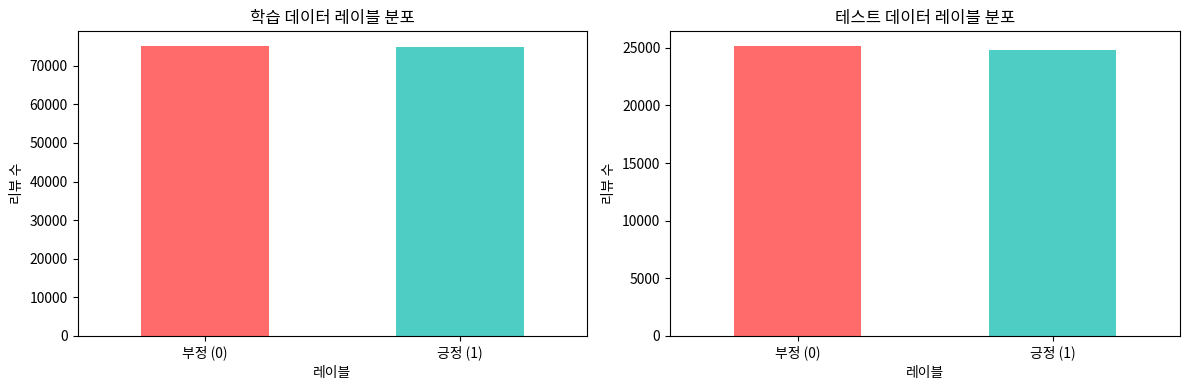

In [7]:
# 레이블 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train_df['label'].value_counts().plot(kind='bar', color=['#ff6b6b', '#4ecdc4'], ax=axes[0])
axes[0].set_xticklabels(['부정 (0)', '긍정 (1)'], rotation=0)
axes[0].set_xlabel('레이블')
axes[0].set_ylabel('리뷰 수')
axes[0].set_title('학습 데이터 레이블 분포')

test_df['label'].value_counts().plot(kind='bar', color=['#ff6b6b', '#4ecdc4'], ax=axes[1])
axes[1].set_xticklabels(['부정 (0)', '긍정 (1)'], rotation=0)
axes[1].set_xlabel('레이블')
axes[1].set_ylabel('리뷰 수')
axes[1].set_title('테스트 데이터 레이블 분포')

plt.tight_layout()
plt.show()

In [8]:
# 리뷰 길이 분석
train_df['review_length'] = train_df['document'].astype(str).apply(len)

print("리뷰 길이 통계:")
print(train_df['review_length'].describe())

리뷰 길이 통계:
count    150000.000000
mean         35.203487
std          29.531947
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: review_length, dtype: float64


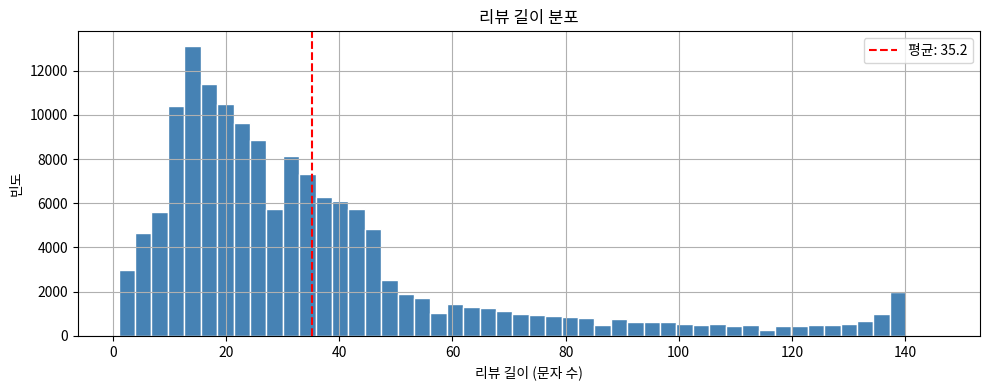

In [9]:
# 리뷰 길이 분포 시각화
fig, ax = plt.subplots(figsize=(10, 4))
train_df['review_length'].hist(bins=50, ax=ax, color='steelblue', edgecolor='white')
ax.set_xlabel('리뷰 길이 (문자 수)')
ax.set_ylabel('빈도')
ax.set_title('리뷰 길이 분포')
ax.axvline(train_df['review_length'].mean(), color='red', linestyle='--', label=f'평균: {train_df["review_length"].mean():.1f}')
ax.legend()
plt.tight_layout()
plt.show()

In [10]:
# 긍정/부정 리뷰 예시 확인
print("=" * 50)
print("긍정 리뷰 예시 (label=1):")
print("=" * 50)
for review in train_df[train_df['label'] == 1]['document'].head(5):
    print(f"• {review}")

print("\n" + "=" * 50)
print("부정 리뷰 예시 (label=0):")
print("=" * 50)
for review in train_df[train_df['label'] == 0]['document'].head(5):
    print(f"• {review}")

긍정 리뷰 예시 (label=1):
• 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
• 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
• 액션이 없는데도 재미 있는 몇안되는 영화
• 왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?
• 걍인피니트가짱이다.진짜짱이다♥

부정 리뷰 예시 (label=0):
• 아 더빙.. 진짜 짜증나네요 목소리
• 너무재밓었다그래서보는것을추천한다
• 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
• 막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
• 원작의 긴장감을 제대로 살려내지못했다.


### 1.2 데이터 전처리

In [11]:
# 결측치 확인
print("학습 데이터 결측치:")
print(train_df.isna().sum())
print("\n테스트 데이터 결측치:")
print(test_df.isna().sum())

학습 데이터 결측치:
Unnamed: 0       0
id               0
document         5
label            0
review_length    0
dtype: int64

테스트 데이터 결측치:
Unnamed: 0    0
id            0
document      3
label         0
dtype: int64


In [12]:
# 전처리
print(f"전처리 전 - 학습: {len(train_df):,}, 테스트: {len(test_df):,}")

# 1. 결측치 제거
train_df = train_df.dropna(subset=['document'])
test_df = test_df.dropna(subset=['document'])

# 2. 빈 문자열 제거
train_df = train_df[train_df['document'].str.strip() != '']
test_df = test_df[test_df['document'].str.strip() != '']

print(f"전처리 후 - 학습: {len(train_df):,}, 테스트: {len(test_df):,}")

전처리 전 - 학습: 150,000, 테스트: 50,000
전처리 후 - 학습: 149,995, 테스트: 49,997


In [13]:
# 텍스트와 레이블 분리
docs_train = train_df['document'].values  # 학습 텍스트
docs_test = test_df['document'].values    # 테스트 텍스트
y_train = train_df['label'].values        # 학습 레이블
y_test = test_df['label'].values          # 테스트 레이블

print(f"docs_train: {len(docs_train):,}개")
print(f"docs_test: {len(docs_test):,}개")
print(f"\n예시 - docs_train[0]: {docs_train[0]}")
print(f"예시 - y_train[0]: {y_train[0]}")

docs_train: 149,995개
docs_test: 49,997개

예시 - docs_train[0]: 아 더빙.. 진짜 짜증나네요 목소리
예시 - y_train[0]: 0


---
## 2. 텍스트 특성 추출

텍스트 데이터를 기계학습 모델에 입력하려면 숫자 형태로 변환해야 합니다.

### 2.1 Bag-of-Words (CountVectorizer)

Bag-of-Words는 문서를 단어의 출현 빈도로 표현하는 방법입니다.

In [14]:
# 간단한 예시로 Bag-of-Words 이해하기
sample_docs = [
    "영화가 재미있다",
    "영화가 지루하다",
    "재미있고 감동적이다"
]

# CountVectorizer 생성 및 학습
count_vec = CountVectorizer()
sample_matrix = count_vec.fit_transform(sample_docs)

# 어휘 사전 확인
print("어휘 사전:")
print(count_vec.get_feature_names_out())

# 변환된 행렬 확인
print("\nBag-of-Words 행렬:")
print(sample_matrix.toarray())

어휘 사전:
['감동적이다' '영화가' '재미있고' '재미있다' '지루하다']

Bag-of-Words 행렬:
[[0 1 0 1 0]
 [0 1 0 0 1]
 [1 0 1 0 0]]


In [15]:
# DataFrame으로 보기 좋게 표시
bow_df = pd.DataFrame(
    sample_matrix.toarray(),
    columns=count_vec.get_feature_names_out(),
    index=['문서1', '문서2', '문서3']
)
print("Bag-of-Words 표현:")
bow_df

Bag-of-Words 표현:


,감동적이다,영화가,재미있고,재미있다,지루하다
문서1,0,1,0,1,0
문서2,0,1,0,0,1
문서3,1,0,1,0,0


### 2.2 TF-IDF (TfidfVectorizer)

TF-IDF는 단어의 중요도에 가중치를 부여합니다.
- TF (Term Frequency): 문서 내 단어 빈도
- IDF (Inverse Document Frequency): 전체 문서에서의 희귀성

In [16]:
# TfidfVectorizer로 동일한 예시 변환
tfidf_vec = TfidfVectorizer()
tfidf_matrix = tfidf_vec.fit_transform(sample_docs)

# TF-IDF 행렬 확인
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray().round(3),
    columns=tfidf_vec.get_feature_names_out(),
    index=['문서1', '문서2', '문서3']
)
print("TF-IDF 표현:")
tfidf_df

TF-IDF 표현:


,감동적이다,영화가,재미있고,재미있다,지루하다
문서1,0.000,0.605,0.000,0.796,0.000
문서2,0.000,0.605,0.000,0.000,0.796
문서3,0.707,0.000,0.707,0.000,0.000


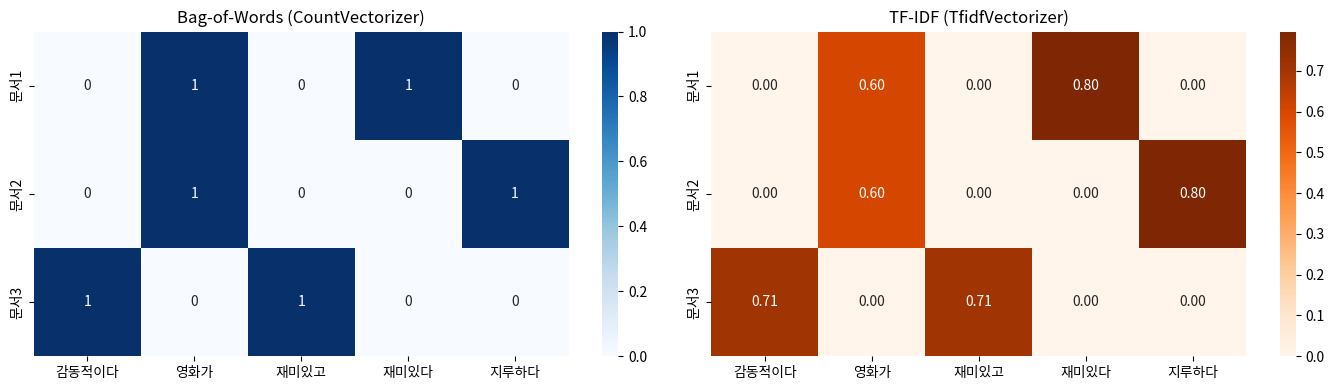

In [17]:
# CountVectorizer vs TfidfVectorizer 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Bag-of-Words
sns.heatmap(bow_df, annot=True, cmap='Blues', ax=axes[0], fmt='d')
axes[0].set_title('Bag-of-Words (CountVectorizer)')

# TF-IDF
sns.heatmap(tfidf_df, annot=True, cmap='Oranges', ax=axes[1], fmt='.2f')
axes[1].set_title('TF-IDF (TfidfVectorizer)')

plt.tight_layout()
plt.show()

**관찰**: 
- Bag-of-Words는 단순 빈도(정수)를 사용합니다.
- TF-IDF는 가중치(실수)를 사용하며, 여러 문서에 등장하는 단어(예: "영화가")는 낮은 값을 갖습니다.

---
## 3. 감정 분석 모델 학습

### 3.1 텍스트 벡터화

**중요**: 학습 데이터로만 `fit_transform()`을 하고, 테스트 데이터는 `transform()`만 합니다.

In [18]:
# TF-IDF 벡터화기 생성
vectorizer = TfidfVectorizer(
    max_features=10000,   # 상위 10,000개 단어만 사용
    min_df=5,             # 최소 5개 문서에 등장한 단어만
    ngram_range=(1, 2)    # 유니그램 + 바이그램
)

# 학습 데이터로 어휘 사전 구축 및 변환 -> X_train
X_train = vectorizer.fit_transform(docs_train)

# 테스트 데이터는 변환만! (fit 하지 않음) -> X_test
X_test = vectorizer.transform(docs_test)

print(f"X_train 형태: {X_train.shape}")
print(f"X_test 형태: {X_test.shape}")
print(f"\n어휘 사전 크기: {len(vectorizer.get_feature_names_out()):,}개")

X_train 형태: (149995, 10000)
X_test 형태: (49997, 10000)

어휘 사전 크기: 10,000개


In [19]:
# 어휘 사전 일부 확인
vocab = vectorizer.get_feature_names_out()
print("어휘 사전 예시 (처음 20개):")
print(vocab[:20])

print("\n어휘 사전 예시 (마지막 20개):")
print(vocab[-20:])

어휘 사전 예시 (처음 20개):
['007' '0개는' '0점' '0점도' '0점은' '0점은 없나' '0점을' '0점이' '10' '100' '100점' '10개'
 '10년' '10년도' '10년이' '10년이 지난' '10년전' '10년전에' '10대' '10번']

어휘 사전 예시 (마지막 20개):
['히어로' '히어로물' '힐링' '힐링이' '힘내세요' '힘든' '힘든 영화' '힘든데' '힘들' '힘들게' '힘들고' '힘들다'
 '힘들듯' '힘들어' '힘들었다' '힘들었음' '힘듬' '힘으로' '힘을' '힘이']


### 3.2 로지스틱 회귀 모델 학습

In [20]:
# 로지스틱 회귀 모델 생성 및 학습
model = LogisticRegression(
    max_iter=1000,    # 충분한 반복 횟수
    random_state=42,
    n_jobs=-1         # 모든 CPU 코어 사용
)

# 모델 학습 (18강과 동일한 형태!)
print("모델 학습 중...")
model.fit(X_train, y_train)
print("모델 학습 완료!")

print(f"\n가중치 형태: {model.coef_.shape}")

모델 학습 중...
모델 학습 완료!

가중치 형태: (1, 10000)


---
## 4. 모델 평가

### 4.1 정확도 계산

In [21]:
# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"테스트 정확도: {accuracy:.4f} ({accuracy*100:.2f}%)")

테스트 정확도: 0.7903 (79.03%)


In [22]:
# 학습 데이터에 대한 정확도 (과적합 확인용)
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"학습 정확도: {train_accuracy:.4f}")
print(f"테스트 정확도: {accuracy:.4f}")
print(f"\n차이: {train_accuracy - accuracy:.4f}")

학습 정확도: 0.8150
테스트 정확도: 0.7903

차이: 0.0247


### 4.2 분류 보고서

In [23]:
# 상세 평가 보고서 출력
print("분류 보고서:")
print("=" * 55)
print(classification_report(y_test, y_pred, target_names=['부정', '긍정']))

분류 보고서:
              precision    recall  f1-score   support

          부정       0.76      0.84      0.80     24826
          긍정       0.83      0.74      0.78     25171

    accuracy                           0.79     49997
   macro avg       0.79      0.79      0.79     49997
weighted avg       0.79      0.79      0.79     49997



### 4.3 혼동 행렬

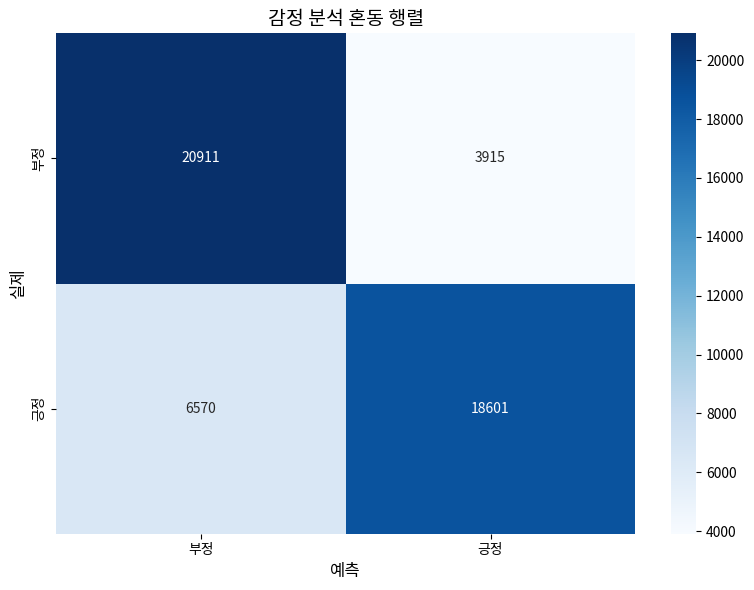

참 음성 (TN): 20,911 - 부정을 부정으로 올바르게 예측
거짓 양성 (FP): 3,915 - 부정을 긍정으로 잘못 예측
거짓 음성 (FN): 6,570 - 긍정을 부정으로 잘못 예측
참 양성 (TP): 18,601 - 긍정을 긍정으로 올바르게 예측


In [24]:
# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 시각화
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['부정', '긍정'],
            yticklabels=['부정', '긍정'],
            ax=ax)
ax.set_xlabel('예측', fontsize=12)
ax.set_ylabel('실제', fontsize=12)
ax.set_title('감정 분석 혼동 행렬', fontsize=14)
plt.tight_layout()
plt.show()

# 수치 해석
tn, fp, fn, tp = cm.ravel()
print(f"참 음성 (TN): {tn:,} - 부정을 부정으로 올바르게 예측")
print(f"거짓 양성 (FP): {fp:,} - 부정을 긍정으로 잘못 예측")
print(f"거짓 음성 (FN): {fn:,} - 긍정을 부정으로 잘못 예측")
print(f"참 양성 (TP): {tp:,} - 긍정을 긍정으로 올바르게 예측")

---
## 5. 결과 분석

### 5.1 중요 단어 분석

로지스틱 회귀 모델의 가중치를 분석하면 긍정/부정 예측에 중요한 단어를 확인할 수 있습니다.

In [25]:
# 특성 이름(단어)과 가중치 가져오기
feature_names = vectorizer.get_feature_names_out()
weights = model.coef_[0]

# 가중치를 DataFrame으로 정리
weight_df = pd.DataFrame({
    'word': feature_names,
    'weight': weights
}).sort_values('weight', ascending=False)

print(f"총 단어 수: {len(weight_df):,}")

총 단어 수: 10,000


In [26]:
# 긍정 예측에 중요한 단어 Top 20
print("긍정 예측에 중요한 단어 Top 20:")
print("=" * 40)
top_positive = weight_df.head(20)
for i, (_, row) in enumerate(top_positive.iterrows(), 1):
    print(f"{i:2}. {row['word']:15} (가중치: {row['weight']:.4f})")

긍정 예측에 중요한 단어 Top 20:
 1. 여운이             (가중치: 5.3381)
 2. 최고              (가중치: 5.2669)
 3. 최고의             (가중치: 4.9195)
 4. 수작              (가중치: 4.6717)
 5. 최고다             (가중치: 4.5759)
 6. 좋았어요            (가중치: 4.2126)
 7. 재미있어요           (가중치: 4.1934)
 8. 좋고              (가중치: 4.0132)
 9. 명작              (가중치: 3.9605)
10. 가슴이             (가중치: 3.9277)
11. 재밌음             (가중치: 3.9060)
12. 재밌다             (가중치: 3.8644)
13. 10점준다           (가중치: 3.8208)
14. 생각하게            (가중치: 3.7929)
15. 재미있었어요          (가중치: 3.7877)
16. 좋았습니다           (가중치: 3.7874)
17. 재밌네요            (가중치: 3.7737)
18. 재밌어요            (가중치: 3.7622)
19. 명작이다            (가중치: 3.7453)
20. 재미있게            (가중치: 3.7400)


In [27]:
# 부정 예측에 중요한 단어 Top 20
print("부정 예측에 중요한 단어 Top 20:")
print("=" * 40)
top_negative = weight_df.tail(20).iloc[::-1]  # 역순
for i, (_, row) in enumerate(top_negative.iterrows(), 1):
    print(f"{i:2}. {row['word']:15} (가중치: {row['weight']:.4f})")

부정 예측에 중요한 단어 Top 20:
 1. 최악의             (가중치: -7.2231)
 2. 최악              (가중치: -6.0193)
 3. 아깝다             (가중치: -5.5593)
 4. 쓰레기             (가중치: -5.4385)
 5. 졸작              (가중치: -5.1715)
 6. 지루하다            (가중치: -5.0182)
 7. 쓰레기영화           (가중치: -5.0038)
 8. 1점도             (가중치: -4.7692)
 9. 재미없다            (가중치: -4.7562)
10. 차라리             (가중치: -4.6209)
11. 최악이다            (가중치: -4.6133)
12. 별로              (가중치: -4.3782)
13. 노잼              (가중치: -4.2416)
14. 재미없는            (가중치: -4.2128)
15. 지루하고            (가중치: -4.1428)
16. 별로다             (가중치: -4.0871)
17. 아까움             (가중치: -4.0702)
18. 망작              (가중치: -3.9728)
19. 재미없어            (가중치: -3.9544)
20. 지루함             (가중치: -3.9313)


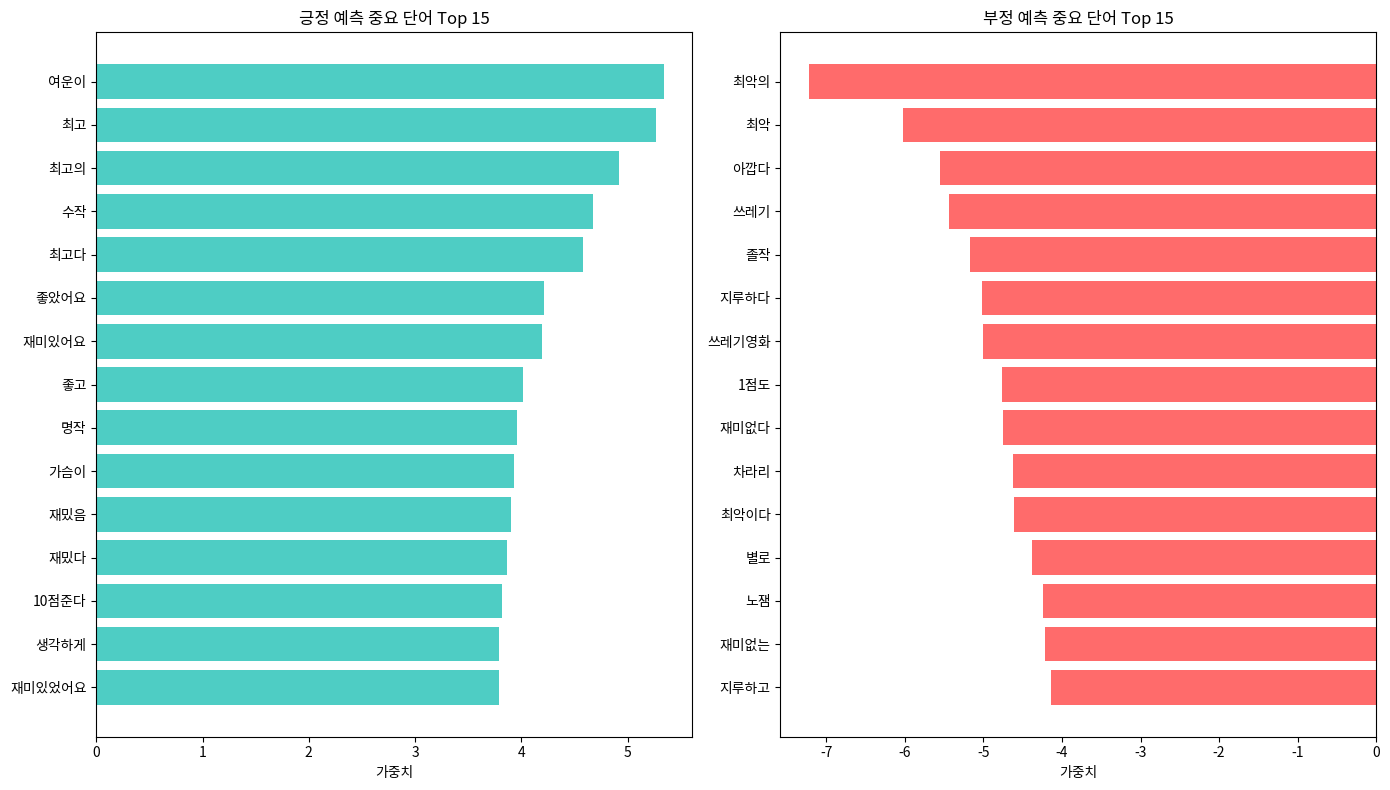

In [28]:
# 중요 단어 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# 긍정 단어
top_pos = weight_df.head(15)
axes[0].barh(top_pos['word'], top_pos['weight'], color='#4ecdc4')
axes[0].set_xlabel('가중치')
axes[0].set_title('긍정 예측 중요 단어 Top 15', fontsize=12)
axes[0].invert_yaxis()

# 부정 단어
top_neg = weight_df.tail(15).iloc[::-1]
axes[1].barh(top_neg['word'], top_neg['weight'], color='#ff6b6b')
axes[1].set_xlabel('가중치')
axes[1].set_title('부정 예측 중요 단어 Top 15', fontsize=12)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### 5.2 오분류 사례 분석

In [29]:
# 오분류된 샘플 찾기
misclassified_idx = np.where(y_pred != y_test)[0]
print(f"오분류된 샘플 수: {len(misclassified_idx):,}개")
print(f"오분류율: {len(misclassified_idx) / len(y_test) * 100:.2f}%")

오분류된 샘플 수: 10,485개
오분류율: 20.97%


In [30]:
# 부정을 긍정으로 잘못 예측한 사례 (FP)
fp_idx = misclassified_idx[(y_test[misclassified_idx] == 0) & (y_pred[misclassified_idx] == 1)]

print("부정인데 긍정으로 잘못 예측한 사례:")
print("=" * 50)
for i, idx in enumerate(fp_idx[:5], 1):
    prob = model.predict_proba(X_test[idx])[0]
    print(f"{i}. \"{docs_test[idx]}\"")
    print(f"   실제: 부정, 예측: 긍정 (확률: {prob[1]:.2%})\n")

부정인데 긍정으로 잘못 예측한 사례:
1. "3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??"
   실제: 부정, 예측: 긍정 (확률: 50.43%)

2. "일본 천황이 미국으로부터 받은 면죄부의 긴박한 과정을 루즈하고 지저분하게 늘어놓았다."
   실제: 부정, 예측: 긍정 (확률: 58.06%)

3. "101, 102.. 103은 못나올것 같다."
   실제: 부정, 예측: 긍정 (확률: 58.52%)

4. "북괴는 우리의 주적일뿐이다."
   실제: 부정, 예측: 긍정 (확률: 87.85%)

5. "레이토와 다미앙의 시원한 액션은 어디갔나 ㅁㅊ"
   실제: 부정, 예측: 긍정 (확률: 58.46%)



In [31]:
# 긍정을 부정으로 잘못 예측한 사례 (FN)
fn_idx = misclassified_idx[(y_test[misclassified_idx] == 1) & (y_pred[misclassified_idx] == 0)]

print("긍정인데 부정으로 잘못 예측한 사례:")
print("=" * 50)
for i, idx in enumerate(fn_idx[:5], 1):
    prob = model.predict_proba(X_test[idx])[0]
    print(f"{i}. \"{docs_test[idx]}\"")
    print(f"   실제: 긍정, 예측: 부정 (확률: {prob[0]:.2%})\n")

긍정인데 부정으로 잘못 예측한 사례:
1. "굳 ㅋ"
   실제: 긍정, 예측: 부정 (확률: 52.61%)

2. "괜찮네요오랜만포켓몬스터잼밌어요"
   실제: 긍정, 예측: 부정 (확률: 52.61%)

3. "눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다."
   실제: 긍정, 예측: 부정 (확률: 66.54%)

4. "소위 ㅈ문가라는 평점은 뭐냐?"
   실제: 긍정, 예측: 부정 (확률: 87.31%)

5. "나이스"
   실제: 긍정, 예측: 부정 (확률: 52.61%)



---
## 6. 새로운 리뷰 예측하기

In [32]:
def predict_sentiment(reviews, vectorizer, model):
    """
    새로운 리뷰의 감정을 예측하는 함수
    
    Parameters:
    - reviews: 리뷰 텍스트 리스트
    - vectorizer: 학습된 TfidfVectorizer
    - model: 학습된 분류 모델
    
    Returns:
    - 예측 결과 DataFrame
    """
    # 벡터화
    X_new = vectorizer.transform(reviews)
    
    # 예측
    predictions = model.predict(X_new)
    probabilities = model.predict_proba(X_new)
    
    # 결과 정리
    results = []
    for review, pred, prob in zip(reviews, predictions, probabilities):
        sentiment = "긍정 👍" if pred == 1 else "부정 👎"
        confidence = max(prob) * 100
        results.append({
            '리뷰': review[:50] + ('...' if len(review) > 50 else ''),
            '예측': sentiment,
            '확신도': f"{confidence:.1f}%",
            '부정 확률': f"{prob[0]:.2%}",
            '긍정 확률': f"{prob[1]:.2%}"
        })
    
    return pd.DataFrame(results)

In [33]:
# 새로운 리뷰로 테스트
new_reviews = [
    "정말 재미있고 감동적인 영화였어요! 강력 추천합니다.",
    "시간 낭비했다. 최악의 영화. 다시는 안 볼 듯.",
    "그냥 그랬다. 볼만하긴 한데 특별히 기억에 남지는 않네요.",
    "배우들 연기는 좋았는데 스토리가 너무 뻔했어요.",
    "올해 본 영화 중 최고! 꼭 보세요!",
    "지루해서 중간에 껐다",
    "ㅋㅋㅋ 웃겨서 재밌게 봤어요",
    "기대했는데 실망이네요..."
]

# 예측 수행
results_df = predict_sentiment(new_reviews, vectorizer, model)
results_df

,리뷰,예측,확신도,부정 확률,긍정 확률
0,정말 재미있고 감동적인 영화였어요! 강력 추천합니다.,긍정 👍,99.0%,0.97%,99.03%
1,시간 낭비했다. 최악의 영화. 다시는 안 볼 듯.,부정 👎,99.7%,99.74%,0.26%
2,그냥 그랬다. 볼만하긴 한데 특별히 기억에 남지는 않네요.,부정 👎,77.9%,77.93%,22.07%
3,배우들 연기는 좋았는데 스토리가 너무 뻔했어요.,부정 👎,85.7%,85.74%,14.26%
4,올해 본 영화 중 최고! 꼭 보세요!,긍정 👍,94.8%,5.25%,94.75%
5,지루해서 중간에 껐다,부정 👎,98.4%,98.35%,1.65%
6,ㅋㅋㅋ 웃겨서 재밌게 봤어요,긍정 👍,96.8%,3.25%,96.75%
7,기대했는데 실망이네요...,부정 👎,96.5%,96.52%,3.48%


In [34]:
# 직접 리뷰를 입력해서 테스트해보세요!
my_review = input("영화 리뷰를 입력하세요: ")

if my_review.strip():
    result = predict_sentiment([my_review], vectorizer, model)
    print("\n예측 결과:")
    print(result.to_string(index=False))


예측 결과:
   리뷰   예측   확신도  부정 확률  긍정 확률
졸려... 부정 👎 88.6% 88.56% 11.44%


---
## 7. 모델 개선 실험 (선택)

### 7.1 다양한 설정 비교

In [35]:
# 여러 설정을 비교하는 실험
experiments = [
    {'name': 'baseline', 'max_features': 10000, 'ngram_range': (1, 1)},
    {'name': 'bigram', 'max_features': 10000, 'ngram_range': (1, 2)},
    {'name': 'more_features', 'max_features': 20000, 'ngram_range': (1, 2)},
    {'name': 'trigram', 'max_features': 10000, 'ngram_range': (1, 3)},
]

results = []

for exp in experiments:
    print(f"실험: {exp['name']}...")
    
    # 벡터화
    vec = TfidfVectorizer(
        max_features=exp['max_features'],
        ngram_range=exp['ngram_range'],
        min_df=5
    )
    X_tr = vec.fit_transform(docs_train)
    X_te = vec.transform(docs_test)
    
    # 모델 학습
    m = LogisticRegression(max_iter=1000, random_state=42)
    m.fit(X_tr, y_train)
    
    # 평가
    acc = m.score(X_te, y_test)
    results.append({
        '실험': exp['name'],
        'max_features': exp['max_features'],
        'ngram_range': str(exp['ngram_range']),
        '정확도': f"{acc:.4f}"
    })

# 결과 비교
print("\n실험 결과:")
pd.DataFrame(results)

실험: baseline...
실험: bigram...
실험: more_features...
실험: trigram...

실험 결과:


,실험,max_features,ngram_range,정확도
0,baseline,10000,"(1, 1)",0.7915
1,bigram,10000,"(1, 2)",0.7903
2,more_features,20000,"(1, 2)",0.8010
3,trigram,10000,"(1, 3)",0.7900


### 7.2 정규화 강도 비교

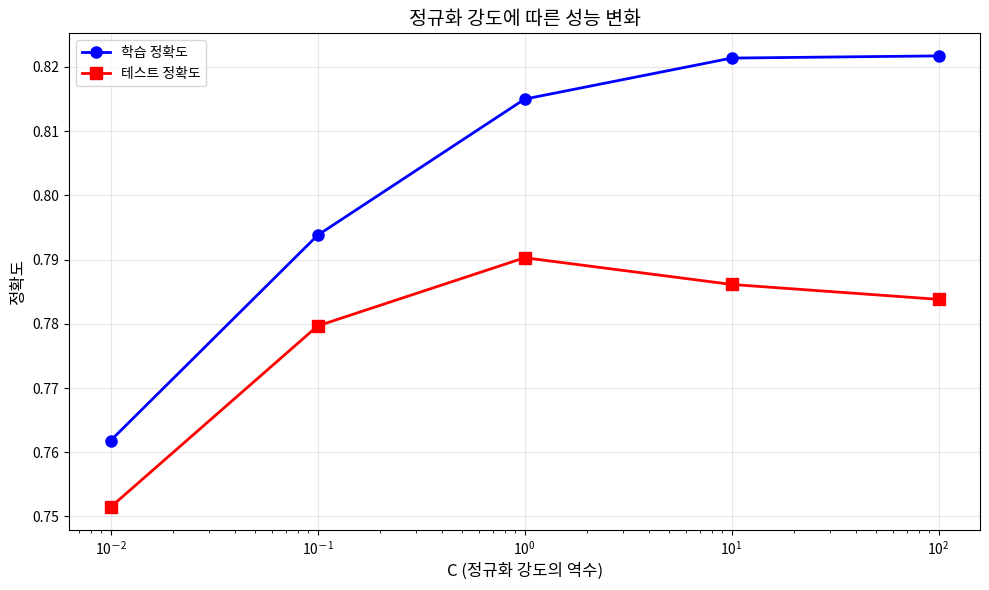

,C,학습 정확도,테스트 정확도
0,0.01,0.7618,0.7515
1,0.10,0.7938,0.7797
2,1.00,0.8150,0.7903
3,10.00,0.8214,0.7861
4,100.00,0.8217,0.7838


In [36]:
# C 값(정규화 강도)에 따른 성능 비교
C_values = [0.01, 0.1, 1, 10, 100]
train_scores = []
test_scores = []

for C in C_values:
    m = LogisticRegression(C=C, max_iter=1000, random_state=42)
    m.fit(X_train, y_train)
    
    train_scores.append(m.score(X_train, y_train))
    test_scores.append(m.score(X_test, y_test))

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(C_values, train_scores, 'b-o', label='학습 정확도', linewidth=2, markersize=8)
ax.plot(C_values, test_scores, 'r-s', label='테스트 정확도', linewidth=2, markersize=8)
ax.set_xscale('log')
ax.set_xlabel('C (정규화 강도의 역수)', fontsize=12)
ax.set_ylabel('정확도', fontsize=12)
ax.set_title('정규화 강도에 따른 성능 변화', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 결과 표
reg_results = pd.DataFrame({
    'C': C_values,
    '학습 정확도': [f"{s:.4f}" for s in train_scores],
    '테스트 정확도': [f"{s:.4f}" for s in test_scores]
})
reg_results

---
## 8. 정리

### 오늘 배운 내용

1. **텍스트 특성 추출**
   - Bag-of-Words: 단어의 출현 빈도로 문서 표현
   - TF-IDF: 단어의 중요도에 가중치 부여
   - `CountVectorizer`, `TfidfVectorizer` 사용법

2. **NSMC 감정 분석**
   - HuggingFace에서 train/test가 분리된 데이터 로드
   - 전처리 → 벡터화(`X_train`, `X_test`) → 학습 → 평가 파이프라인
   - TF-IDF + 로지스틱 회귀로 약 80% 정확도 달성

3. **결과 분석**
   - 혼동 행렬로 오류 패턴 파악
   - 가중치 분석으로 중요 단어 확인
   - 오분류 사례 분석

### 핵심 포인트
- 테스트 데이터에는 `transform()`만 사용 (데이터 누수 방지)
- `X_train`, `X_test`는 벡터화된 특성 행렬 (18강과 동일한 형태)
- 모델의 가중치 분석을 통해 예측 근거 해석 가능
- n-그램, 정규화 등으로 모델 성능 개선 가능

---
## 연습 문제

1. `max_features`를 5000, 15000, 30000으로 바꿔보고 성능 변화를 관찰하세요.

2. `ngram_range=(2, 2)`로 바이그램만 사용했을 때의 성능을 측정해보세요.

3. 가장 혼란스러운 리뷰(예측 확률이 0.5에 가까운 리뷰)를 찾아 분석해보세요.

4. 자신만의 영화 리뷰 10개를 작성하고 모델의 예측이 맞는지 확인해보세요.

In [37]:
# 연습 문제를 위한 빈 셀
# 여기에 코드를 작성하세요.
